# Conditional Generative Advarsarial Network 

Here is presented the following parper https://arxiv.org/abs/1411.1784

This work is similar to the previous one but now the G(z) is replaced with G(z|y) and D(x) by D(x|y). 
Since we only need to modify the Generator and Discriminator network the previous code dont change to much (loss, otimization)

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


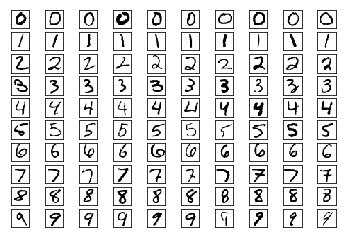

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")

#ut.plot_mnist_images(mnist.test.images[0:9])

#reset graph using during notebook development
#tf.reset_default_graph()
images_per_class = 10
images = np.zeros((10*images_per_class,mnist_flat_size))
for l in range(10):
    images[(l*images_per_class):(l*images_per_class+images_per_class)] = mnist.test.images[(mnist.test.labels==l)][:images_per_class]
    
ut.plot_mnist_images_conditonal(images,per_class = images_per_class)


### Generator network 

Same as previous network, only diference is that input Z is concatenated with y

In [3]:
#array that contain the network dimention at least 3 dimention (input, hidden and output dimentions)
z_dimention = 100

G_dimentions = [z_dimention,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='number_label')

def generator(x,y):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param y: tensor with shape (M,10) labels in one hot encoder
    :return: tensor with shape (M,784) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):

        he_init = tf.contrib.layers.variance_scaling_initializer()
        
        concat_input = tf.concat([x, y], 1)
        
        g_net = tf.layers.dense(concat_input,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        return g_net


### Discriminator network 

Same as previous network, only diference is that input Z is concatenated with y

In [4]:
#array that contain the network dimention at least 3 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput fake, true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x,y):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :param y: tensor with shape (10,1) labels in one hot encoder
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        concat_input = tf.concat([x, y], 1)
        
        d_net = tf.layers.dense(concat_input,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Loss functions Generator and Discriminator

Same as previous one

In [5]:

#this alternative loss use cross entropy (explanation why this makes senses TODO)
alternative_loss = True

with tf.name_scope("generator_loss"): 
    generated_sample = generator(Z,Y)
    d_fake_prob, d_fake_logits = discriminator(generated_sample,Y) #D(G(Z|Y)|Y)
    
    if alternative_loss:
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob, d_true_logits = discriminator(X,Y)
    if alternative_loss:
        d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits, labels=tf.ones_like(d_true_logits)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
        d_loss = d_loss_fake + d_loss_true
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))

#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [6]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'g_hidden1/kernel:0' shape=(20, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(794, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


### Training Algorithm

Epoach 0
Discriminator loss:  1.13992
Generator loss: 2.98808


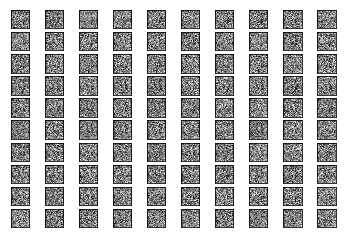

Epoach 1000
Discriminator loss:  0.00394728
Generator loss: 8.01533


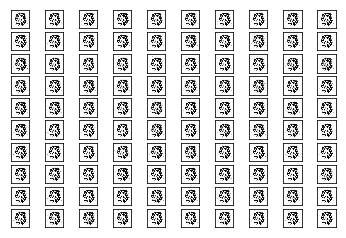

Epoach 2000
Discriminator loss:  0.0678246
Generator loss: 4.87244


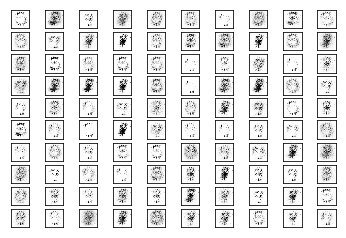

Epoach 3000
Discriminator loss:  0.0637272
Generator loss: 6.57985


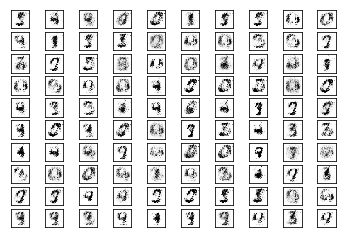

Epoach 4000
Discriminator loss:  0.177997
Generator loss: 4.60471


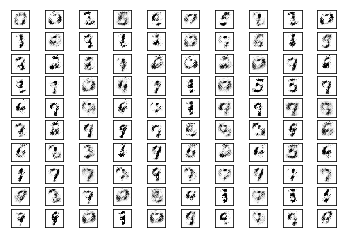

Epoach 5000
Discriminator loss:  0.210083
Generator loss: 4.58648


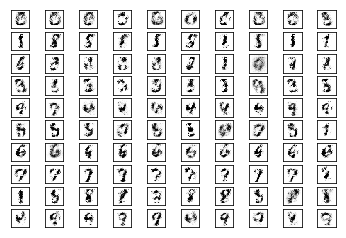

Epoach 6000
Discriminator loss:  0.388882
Generator loss: 4.52871


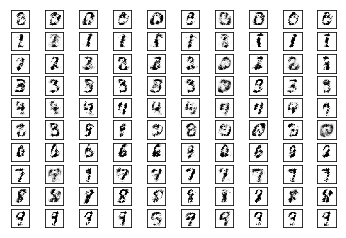

Epoach 7000
Discriminator loss:  0.436291
Generator loss: 3.91943


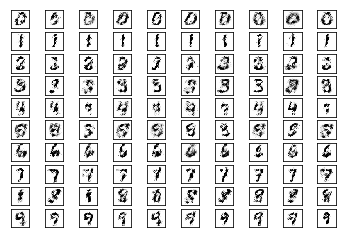

Epoach 8000
Discriminator loss:  0.267914
Generator loss: 4.73824


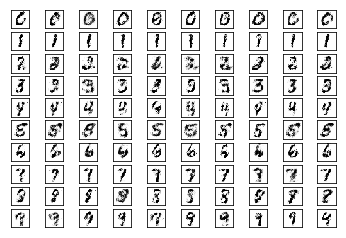

Epoach 9000
Discriminator loss:  0.400651
Generator loss: 3.12725


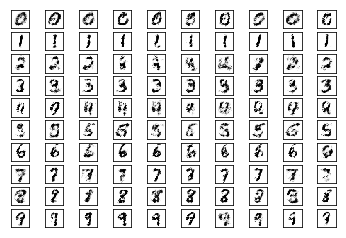

Epoach 10000
Discriminator loss:  0.549468
Generator loss: 3.3859


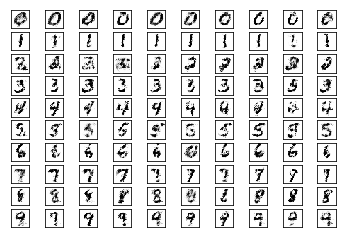

Epoach 11000
Discriminator loss:  0.469888
Generator loss: 3.13138


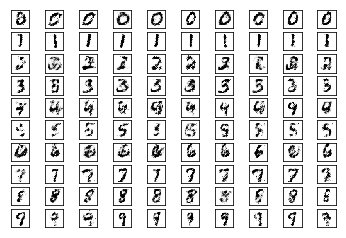

Epoach 12000
Discriminator loss:  0.605756
Generator loss: 2.93068


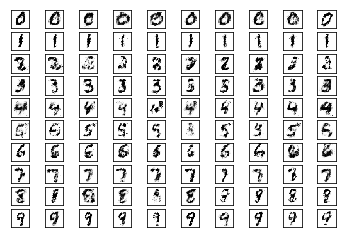

Epoach 13000
Discriminator loss:  0.566459
Generator loss: 2.8237


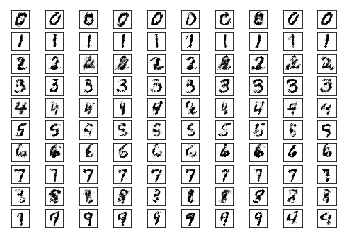

Epoach 14000
Discriminator loss:  0.592152
Generator loss: 2.97913


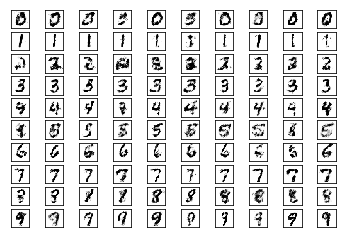

Epoach 15000
Discriminator loss:  0.603791
Generator loss: 2.38205


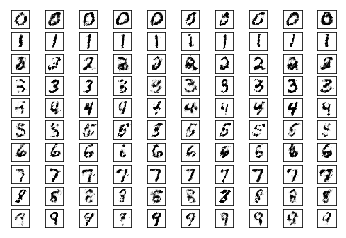

Epoach 16000
Discriminator loss:  0.615023
Generator loss: 2.63601


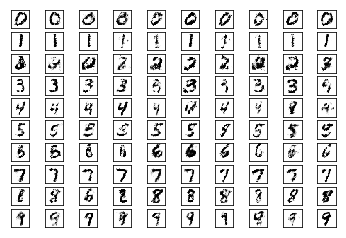

Epoach 17000
Discriminator loss:  0.690433
Generator loss: 2.37486


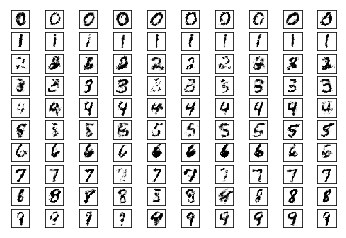

Epoach 18000
Discriminator loss:  0.622158
Generator loss: 2.5869


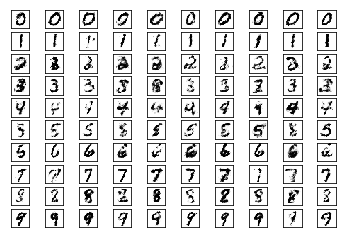

Epoach 19000
Discriminator loss:  0.829891
Generator loss: 2.23128


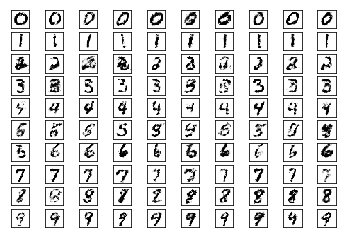

Epoach 20000
Discriminator loss:  0.790408
Generator loss: 1.98047


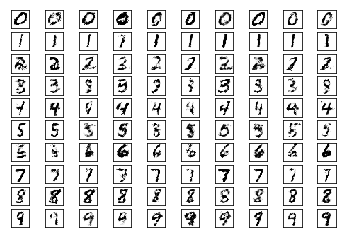

Epoach 21000
Discriminator loss:  0.794743
Generator loss: 2.36056


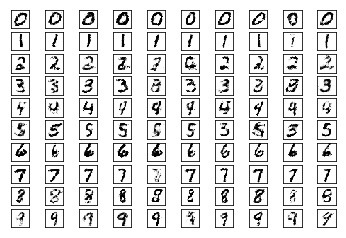

Epoach 22000
Discriminator loss:  0.682512
Generator loss: 2.17154


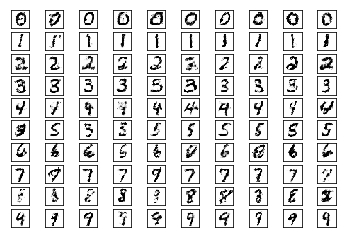

Epoach 23000
Discriminator loss:  0.899823
Generator loss: 2.05316


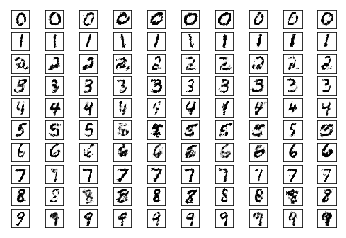

Epoach 24000
Discriminator loss:  0.673847
Generator loss: 1.8333


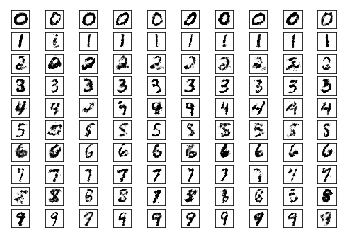

Epoach 25000
Discriminator loss:  0.769182
Generator loss: 1.97008


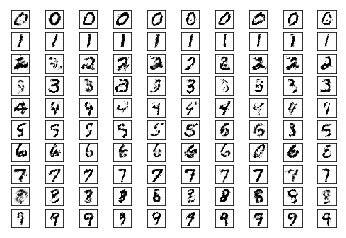

Epoach 26000
Discriminator loss:  0.66633
Generator loss: 2.34428


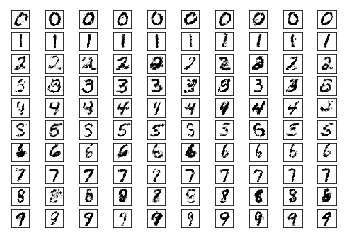

Epoach 27000
Discriminator loss:  0.711466
Generator loss: 1.87848


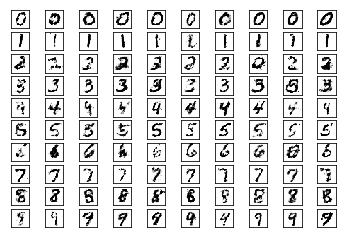

Epoach 28000
Discriminator loss:  0.859557
Generator loss: 2.13695


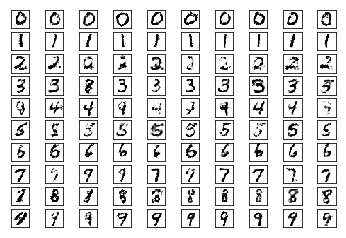

Epoach 29000
Discriminator loss:  0.749325
Generator loss: 2.09789


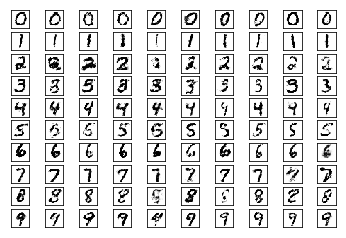

Epoach 30000
Discriminator loss:  0.865559
Generator loss: 1.70943


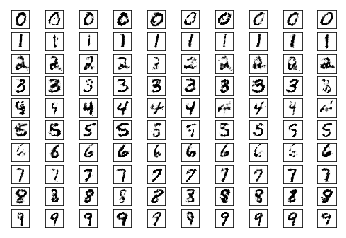

Epoach 31000
Discriminator loss:  0.680064
Generator loss: 2.13674


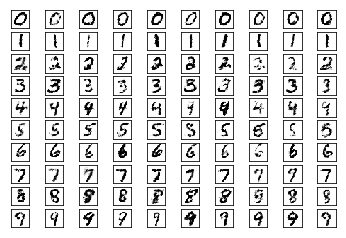

Epoach 32000
Discriminator loss:  0.814751
Generator loss: 2.19053


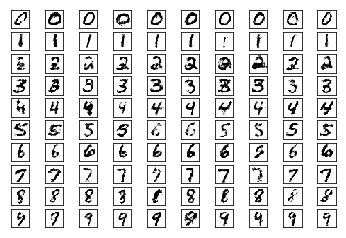

Epoach 33000
Discriminator loss:  0.867556
Generator loss: 2.05277


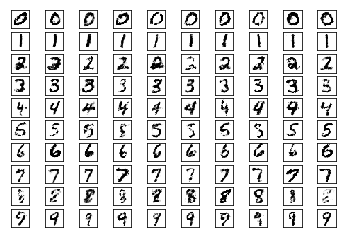

Epoach 34000
Discriminator loss:  0.702541
Generator loss: 2.05603


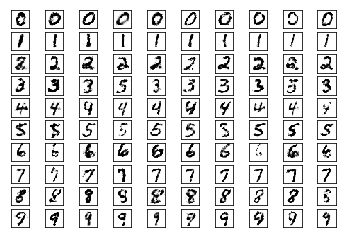

Epoach 35000
Discriminator loss:  0.731419
Generator loss: 1.73565


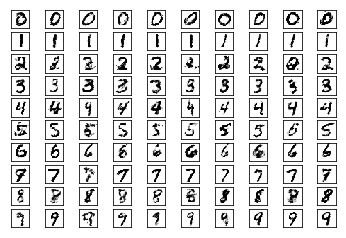

Epoach 36000
Discriminator loss:  0.722864
Generator loss: 1.81299


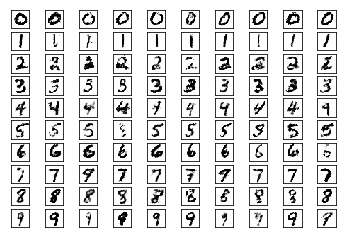

Epoach 37000
Discriminator loss:  0.723775
Generator loss: 1.9027


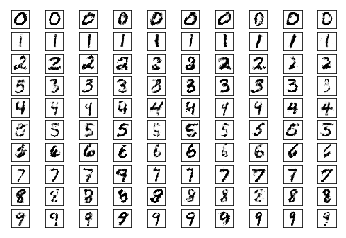

Epoach 38000
Discriminator loss:  0.774284
Generator loss: 1.81018


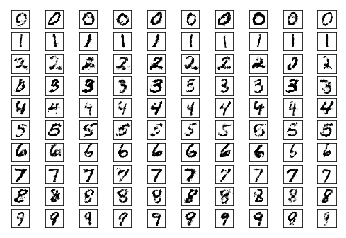

Epoach 39000
Discriminator loss:  0.853554
Generator loss: 2.06915


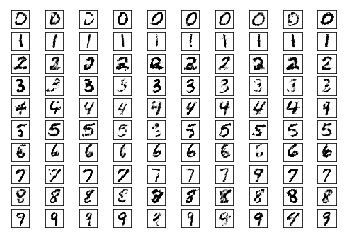

Epoach 40000
Discriminator loss:  0.820095
Generator loss: 1.90223


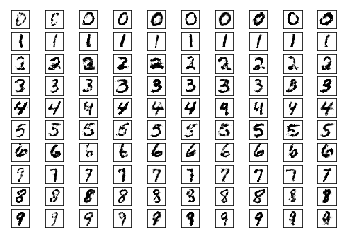

Epoach 41000
Discriminator loss:  0.726598
Generator loss: 2.14894


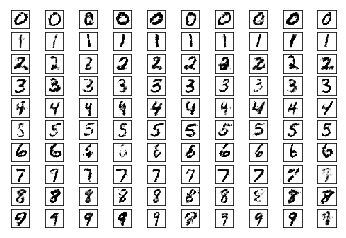

Epoach 42000
Discriminator loss:  0.944774
Generator loss: 1.8973


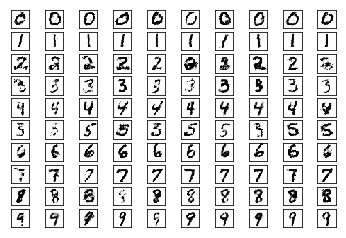

Epoach 43000
Discriminator loss:  0.69657
Generator loss: 2.25571


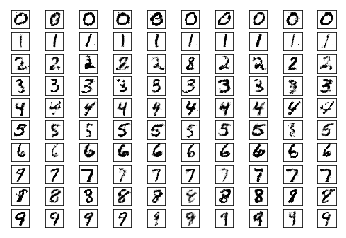

Epoach 44000
Discriminator loss:  0.66401
Generator loss: 2.16563


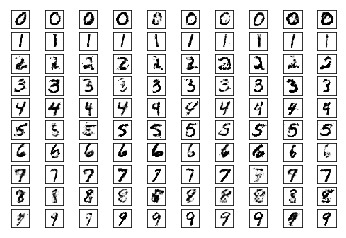

Epoach 45000
Discriminator loss:  0.69271
Generator loss: 2.14241


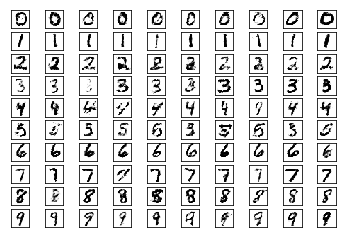

Epoach 46000
Discriminator loss:  0.676191
Generator loss: 1.8861


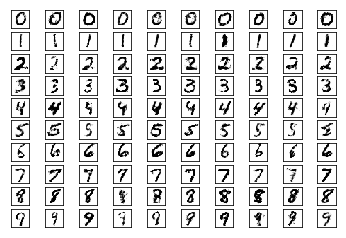

Epoach 47000
Discriminator loss:  0.60022
Generator loss: 2.31068


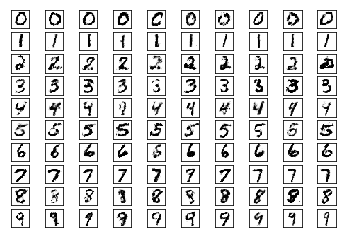

Epoach 48000
Discriminator loss:  0.631846
Generator loss: 2.02332


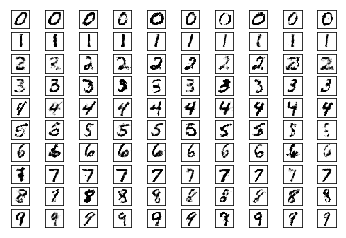

Epoach 49000
Discriminator loss:  0.829409
Generator loss: 2.04966


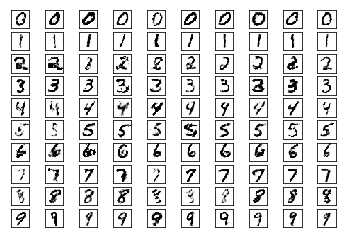

Epoach 50000
Discriminator loss:  0.752779
Generator loss: 1.82411


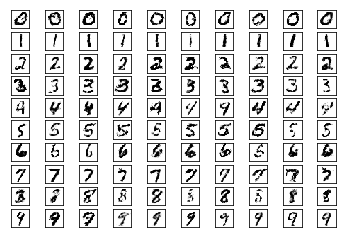

Epoach 51000
Discriminator loss:  0.787712
Generator loss: 2.2202


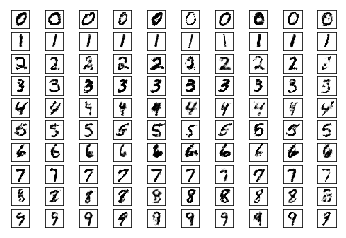

Epoach 52000
Discriminator loss:  0.709075
Generator loss: 2.16962


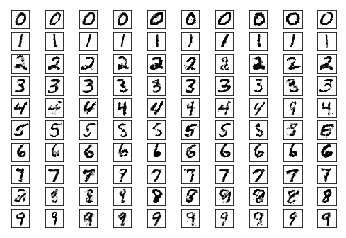

Epoach 53000
Discriminator loss:  0.885789
Generator loss: 1.93874


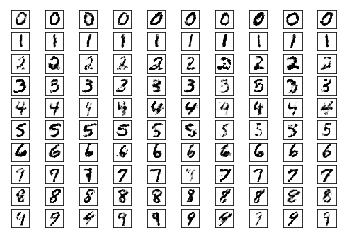

Epoach 54000
Discriminator loss:  0.703709
Generator loss: 2.16875


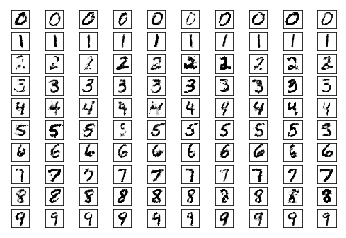

Epoach 55000
Discriminator loss:  0.748867
Generator loss: 1.95686


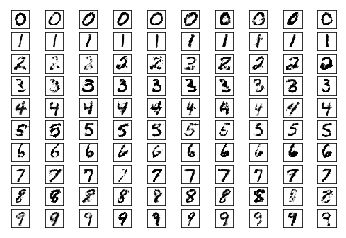

Epoach 56000
Discriminator loss:  0.56058
Generator loss: 2.32235


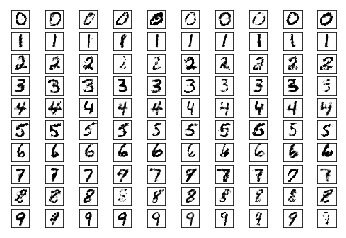

Epoach 57000
Discriminator loss:  0.778372
Generator loss: 1.94888


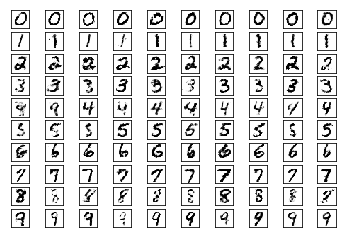

Epoach 58000
Discriminator loss:  0.919278
Generator loss: 1.77277


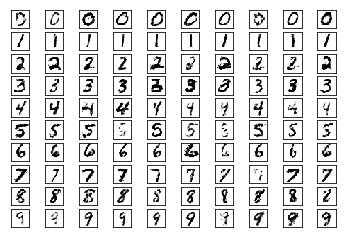

Epoach 59000
Discriminator loss:  0.745838
Generator loss: 2.07413


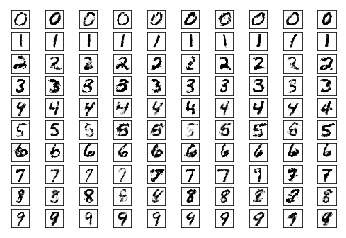

Epoach 60000
Discriminator loss:  0.677651
Generator loss: 2.33131


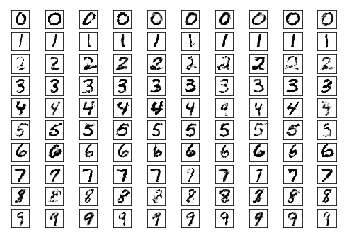

Epoach 61000
Discriminator loss:  0.588513
Generator loss: 2.08178


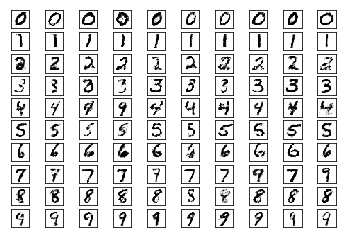

Epoach 62000
Discriminator loss:  0.755598
Generator loss: 1.99314


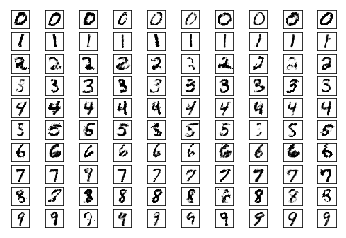

Epoach 63000
Discriminator loss:  0.845176
Generator loss: 2.04944


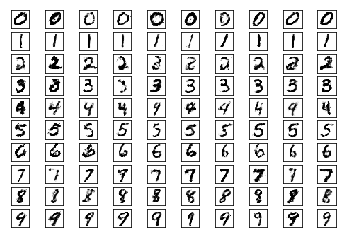

Epoach 64000
Discriminator loss:  0.69387
Generator loss: 1.88516


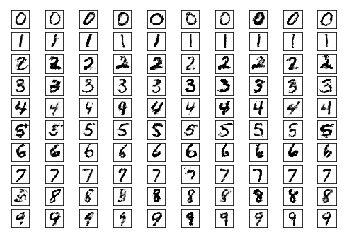

Epoach 65000
Discriminator loss:  0.548713
Generator loss: 1.96196


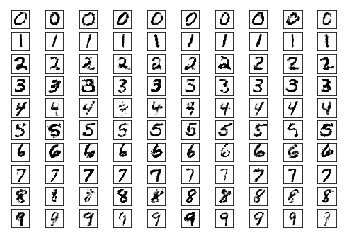

Epoach 66000
Discriminator loss:  0.645655
Generator loss: 2.24019


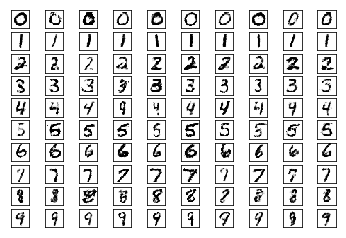

Epoach 67000
Discriminator loss:  0.783003
Generator loss: 1.78088


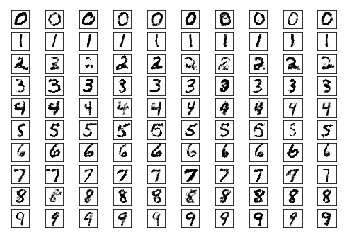

Epoach 68000
Discriminator loss:  0.816192
Generator loss: 1.83279


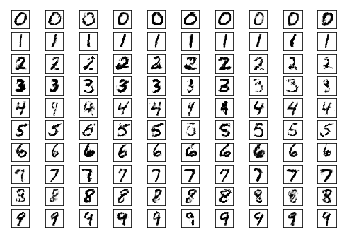

Epoach 69000
Discriminator loss:  0.678126
Generator loss: 2.11727


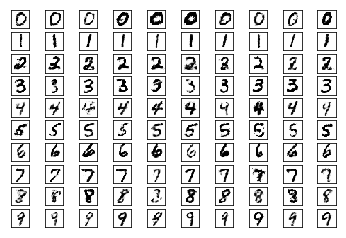

Epoach 70000
Discriminator loss:  0.783727
Generator loss: 1.79259


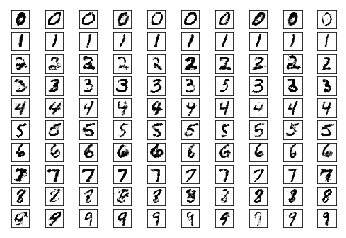

Epoach 71000
Discriminator loss:  0.754981
Generator loss: 1.85019


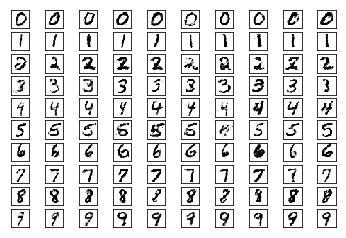

Epoach 72000
Discriminator loss:  0.838634
Generator loss: 2.15971


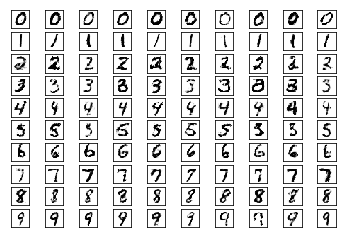

Epoach 73000
Discriminator loss:  0.741457
Generator loss: 1.83079


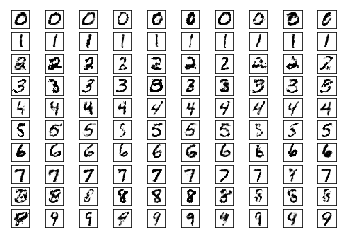

Epoach 74000
Discriminator loss:  0.891543
Generator loss: 1.91053


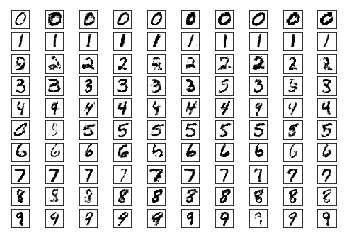

Epoach 75000
Discriminator loss:  0.717445
Generator loss: 2.13246


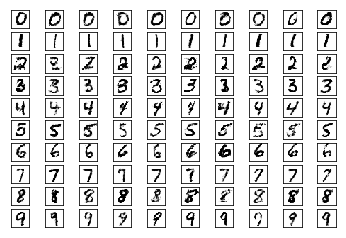

Epoach 76000
Discriminator loss:  0.721487
Generator loss: 2.28154


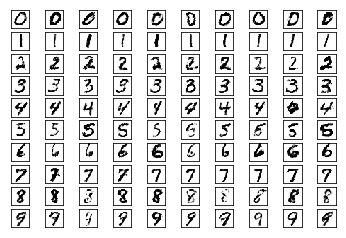

Epoach 77000
Discriminator loss:  0.744296
Generator loss: 2.15627


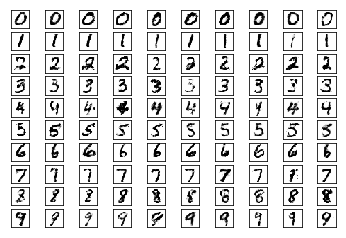

Epoach 78000
Discriminator loss:  0.735293
Generator loss: 1.89889


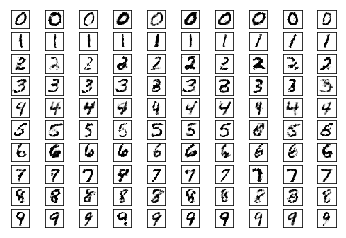

Epoach 79000
Discriminator loss:  0.731581
Generator loss: 2.02266


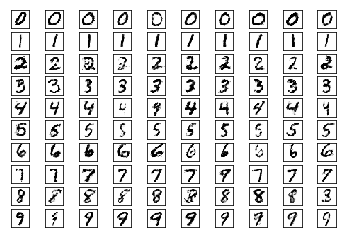

Epoach 80000
Discriminator loss:  0.717509
Generator loss: 2.19541


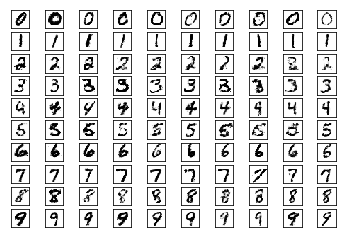

Epoach 81000
Discriminator loss:  0.694534
Generator loss: 2.00974


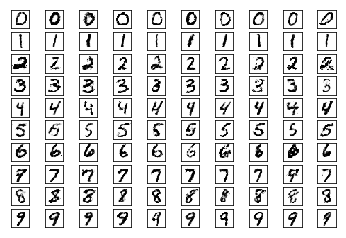

Epoach 82000
Discriminator loss:  0.650851
Generator loss: 2.07186


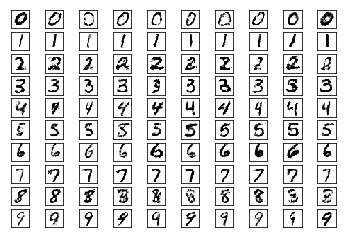

Epoach 83000
Discriminator loss:  0.645092
Generator loss: 2.21884


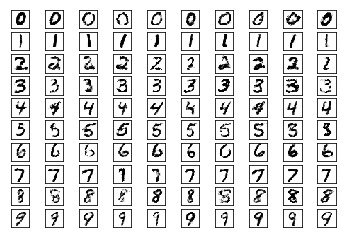

Epoach 84000
Discriminator loss:  0.733609
Generator loss: 2.05814


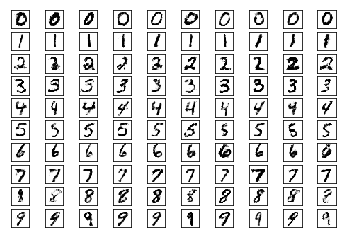

Epoach 85000
Discriminator loss:  0.78961
Generator loss: 1.72411


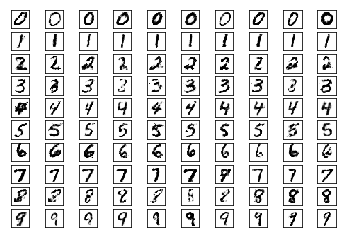

Epoach 86000
Discriminator loss:  0.772753
Generator loss: 1.94924


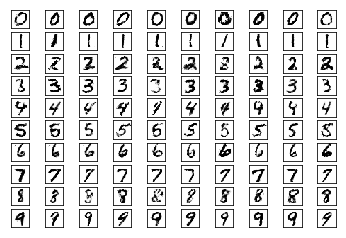

Epoach 87000
Discriminator loss:  0.743491
Generator loss: 2.1126


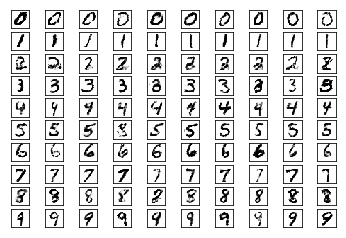

Epoach 88000
Discriminator loss:  0.795741
Generator loss: 1.45687


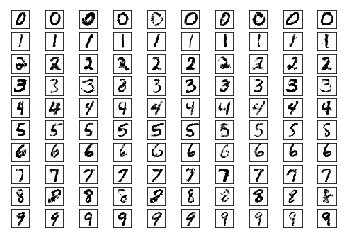

Epoach 89000
Discriminator loss:  0.709524
Generator loss: 1.86207


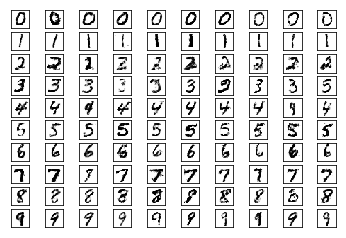

Epoach 90000
Discriminator loss:  0.643754
Generator loss: 2.04722


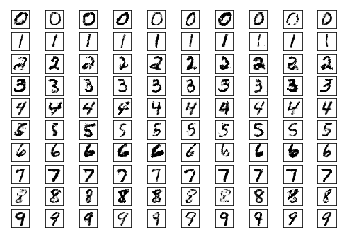

Epoach 91000
Discriminator loss:  0.731699
Generator loss: 2.19514


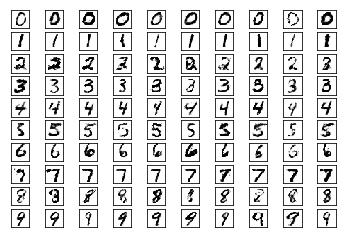

Epoach 92000
Discriminator loss:  0.670325
Generator loss: 1.95865


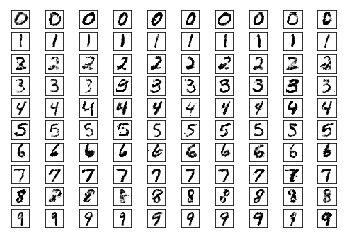

Epoach 93000
Discriminator loss:  0.769724
Generator loss: 1.94953


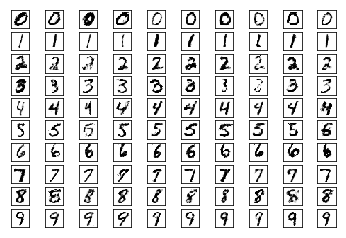

Epoach 94000
Discriminator loss:  0.828356
Generator loss: 1.8558


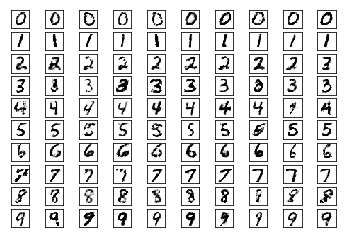

Epoach 95000
Discriminator loss:  0.752793
Generator loss: 1.73147


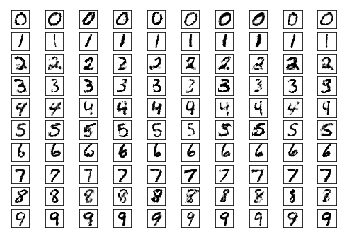

Epoach 96000
Discriminator loss:  0.785722
Generator loss: 2.03894


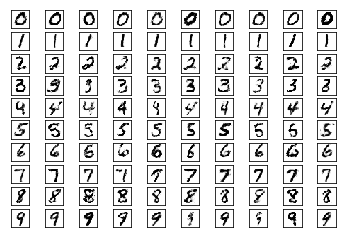

Epoach 97000
Discriminator loss:  0.857663
Generator loss: 2.00504


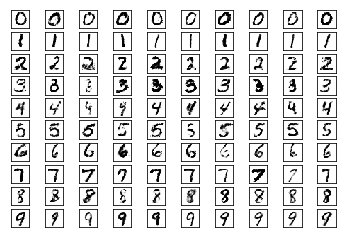

Epoach 98000
Discriminator loss:  0.705292
Generator loss: 2.04225


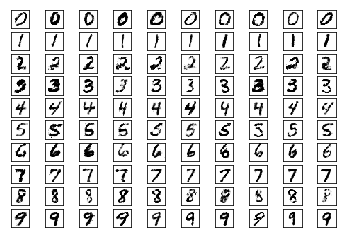

Epoach 99000
Discriminator loss:  0.686214
Generator loss: 2.32923


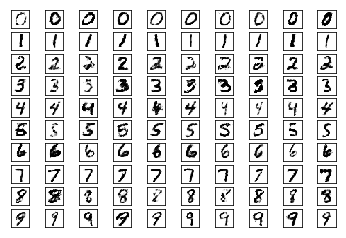

### Play arround with the trained model

[-1.   -0.78 -0.56 -0.34 -0.12  0.1   0.32  0.54  0.76  0.98]


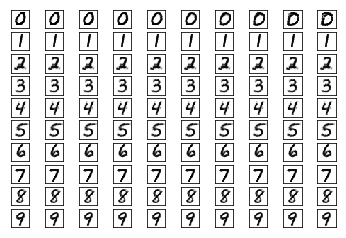

In [31]:
z_noise = np.zeros((images_per_class*10,z_dimention))


range_values = np.arange(-1, 1, 0.22)
print(range_values)
for i in range(len(range_values)):
    z_noise[i][0]=range_values[i]
    
conditional_y = one_hot(np.repeat(list(range(10)), images_per_class))

#valores altos de indice 0 permitem criar 0 mais grosso

ut.plot_mnist_images_conditonal(generated_sample.eval(session=sess,feed_dict={Z: z_noise,Y:conditional_y}),per_class=images_per_class)

### Using the generator to train one classifier

Here i am going to create 3 classifiers, one of then will be train with the train set, other in the generated data and the last in train set + generated data

In [8]:
Classifier_dimentions = [784,128,10]
def classifier(x,name):
    '''
    Classifier network
    
    :param x: tensor with shape (M,784) here M = number of samples
    :return: tensor with shape (M,10) corresponding to the logits
    '''
    with tf.name_scope("classifier_nn_"+name):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        
        d_net = tf.layers.dense(x,Classifier_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='hidden1_'+name,kernel_initializer=he_init)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,Classifier_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='hidden_'+str(i)+name,kernel_initializer=he_init)

        return tf.layers.dense(d_net,Classifier_dimentions[-1],activation=None,name='output_'+name,kernel_initializer=he_init)

clf_train_set = classifier(X,"train_set")
clf_generator_set = classifier(X,"gen_set")
clf_train_generator_set = classifier(X,"train_generator_set")



clf_train_variables = [var for var in tf.trainable_variables() if 'train_set' in var.name]
clf_generator_variables = [var for var in tf.trainable_variables() if 'gen_set' in var.name]
clf_train_generator_variables = [var for var in tf.trainable_variables() if 'train_generator_set' in var.name]

# kernel = weight
print(clf_train_variables)
print(clf_generator_variables)
print(clf_train_generator_variables)

[<tf.Variable 'hidden1_train_set/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'hidden1_train_set/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'output_train_set/kernel:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'output_train_set/bias:0' shape=(10,) dtype=float32_ref>]
[<tf.Variable 'hidden1_gen_set/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'hidden1_gen_set/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'output_gen_set/kernel:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'output_gen_set/bias:0' shape=(10,) dtype=float32_ref>]
[<tf.Variable 'hidden1_train_generator_set/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'hidden1_train_generator_set/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'output_train_generator_set/kernel:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'output_train_generator_set/bias:0' shape=(10,) dtype=float32_ref>]


In [12]:

with tf.name_scope("classifier_loss"):
    clf_train_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=clf_train_set), name="clf_train_loss")
    clf_generator_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=clf_generator_set), name="clf_generator_loss")
    clf_train_generator_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=clf_train_generator_set), name="clf_train_generator_loss")

## Train cGAN and after the classifier

In [15]:
lr = 0.001
with tf.name_scope("classifier_train"):
    clf_train_op = tf.train.AdamOptimizer(lr).minimize(clf_train_loss,var_list=clf_train_variables)
    clf_generator_op = tf.train.AdamOptimizer(lr).minimize(clf_generator_loss,var_list=clf_generator_variables)
    clf_train_generator_op = tf.train.AdamOptimizer(lr).minimize(clf_train_generator_loss,var_list=clf_train_generator_variables)
    
with tf.name_scope("classifier_predict"):
    accuracy_clf_train = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(clf_train_set, 1), tf.argmax(Y, 1)), tf.float32))
    accuracy_clf_generator = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(clf_generator_set, 1), tf.argmax(Y, 1)), tf.float32))
    accuracy_clf_generator_train = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(clf_train_generator_set, 1), tf.argmax(Y, 1)), tf.float32))
    


In [ ]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


def random_Z(m, n=z_dimention):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

def random_y(m):
    '''
    Random labels y in one hot encoding
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return one_hot(np.random.randint(10,size=[m,1]))


def one_hot(label):
    '''
    Apply one hot encoding to the label
    
    :param label: Vector with shape (Mx1)
    :return: Matrix with shape (Mx10)
    '''
    #print(len(label))
    m = np.zeros((len(label),10))
    m[np.arange(len(label)), label] = 1
    return m
    
## Start graph computations and algorithm


batch_size = 128
epoach = 100000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    y_one_hot = one_hot(y_train)
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train,Y:y_one_hot , Z: random_Z(batch_size)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: random_Z(batch_size),Y:y_one_hot})

    if i%1000 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = random_Z(images_per_class*10)
                
        conditional_y = one_hot(np.repeat(list(range(10)), images_per_class))
        
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new,Y:conditional_y})
        ut.plot_mnist_images_conditonal(generated_images,per_class = images_per_class)

In [14]:


batch_size = 128
epoach = 10000

#train classifiers only on train set
for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    y_one_hot = one_hot(y_train)
    
    _, d_loss_value = sess.run([clf_train_op, clf_train_loss], feed_dict={X: x_train,Y:y_one_hot})
    
    if i%1000==0:
        print("clf_train_loss",d_loss_value)
        
        y_one_hot = one_hot(mnist.test.labels)
        acc = sess.run([accuracy_clf_train], feed_dict={X: mnist.test.images,Y:y_one_hot})
        print("acc",acc)
#train classifiers only with generate data
epoach = 1000000 # we can use more iteration because now the date is infinity!
for i in range(epoach+1):
    
    z_sample = random_Z(m=batch_size)
    y_one_hot = random_y(m=batch_size)
    
    x_samples = generated_sample.eval(session=sess,feed_dict={Z: z_sample,Y:y_one_hot})
    
    _, d_loss_value = sess.run([clf_generator_op, clf_generator_loss], feed_dict={X: x_samples,Y:y_one_hot})
    
    if i%1000==0:
        print("clf_train_loss",d_loss_value)
        
        y_one_hot = one_hot(mnist.test.labels)
        acc = sess.run([accuracy_clf_generator], feed_dict={X: mnist.test.images,Y:y_one_hot})
        print("acc",acc)


FailedPreconditionError: Attempting to use uninitialized value classifier_train/beta1_power
	 [[Node: classifier_train/beta1_power/read = Identity[T=DT_FLOAT, _class=["loc:@hidden1_train_set/bias"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](classifier_train/beta1_power)]]
	 [[Node: classifier_loss_2/clf_train_loss/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_190_classifier_loss_2/clf_train_loss", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'classifier_train/beta1_power/read', defined at:
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-ccb007bc8f37>", line 3, in <module>
    clf_train_op = tf.train.AdamOptimizer(lr).minimize(clf_train_loss,var_list=clf_train_variables)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\optimizer.py", line 353, in minimize
    name=name)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\optimizer.py", line 474, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\training\adam.py", line 130, in _create_slots
    trainable=False)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1927, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2070, in identity
    "Identity", input=input, name=name)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value classifier_train/beta1_power
	 [[Node: classifier_train/beta1_power/read = Identity[T=DT_FLOAT, _class=["loc:@hidden1_train_set/bias"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](classifier_train/beta1_power)]]
	 [[Node: classifier_loss_2/clf_train_loss/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_190_classifier_loss_2/clf_train_loss", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
